In [35]:
import numpy as np
import os.path as osp
from os import getcwd
from os import chdir
import sys
data_factory_dir = "../src/"
if osp.exists(data_factory_dir):
    sys.path.insert(0, data_factory_dir)
    from data_factory import combine, preprocess
else:
    print("Folder not exists: %s"%data_factory_dir)
    print(getcwd())
from nltk import FreqDist
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from nltk import word_tokenize

# Preprocess

In [2]:
# set up
train_data_dir = '../data/train/'
train_topics = ['biology', 'cooking', 'crypto', 'diy', 'robotics', 'travel']
train_files = [osp.join(train_data_dir, t+'.csv') for t in train_topics]
train_dict = dict(zip(train_topics, train_files))
test_dict = {'physics': '../data/test/test.csv'}
#
# # load-transform-save
df = combine(train_dict, test_dict)
df = preprocess(df)

Loaded data.
Loaded data.
Removed html tags.
Combined question title and content.
Removed extra spaces and new lines.


In [3]:
topics_dict = dict(zip(range(0, 7), train_topics + ['physics']))
df['topic'] = df['qid'].apply(lambda x: topics_dict[int(x.split("-")[0])])
topics_counter = Counter(list(df['topic']))

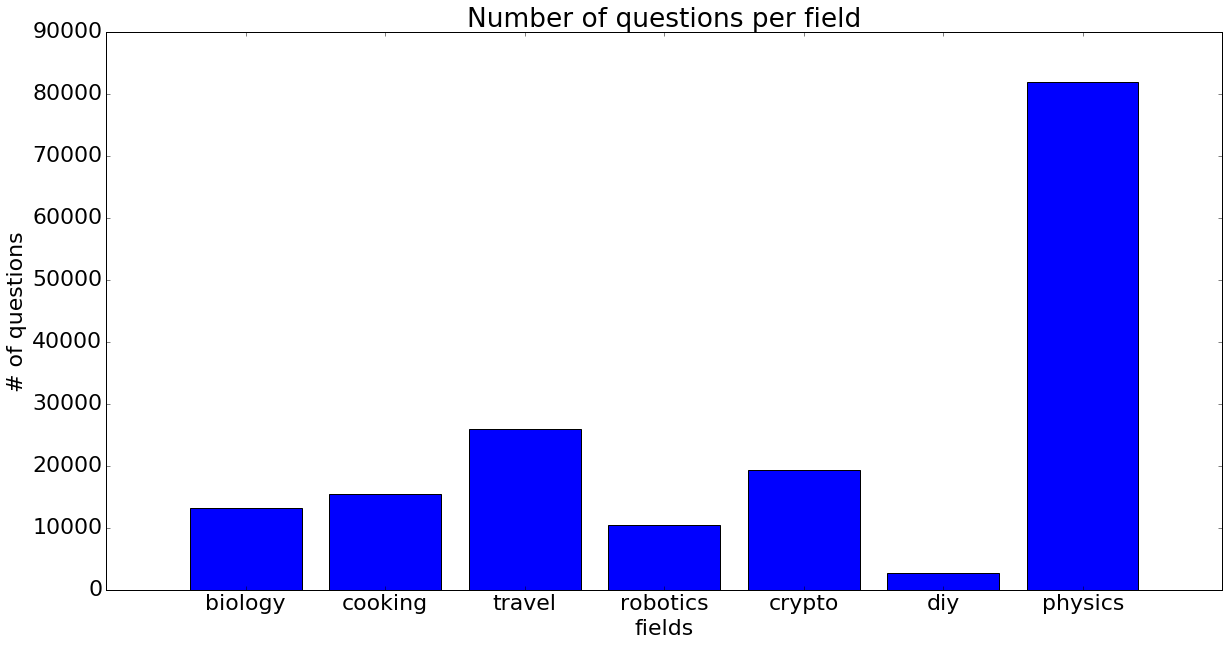

In [34]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
counts = topics_counter.values()
names = topics_counter.keys()
x_coor = np.arange(len(names))
ax.bar(x_coor, counts, align='center')
ax.xaxis.set_major_locator(plt.FixedLocator(x_coor))
ax.xaxis.set_major_formatter(plt.FixedFormatter(names))
ax.set_title("Number of questions per field")
ax.set_ylabel("# of questions")
ax.set_xlabel("fields")
plt.show()

In [35]:
df.columns

Index([u'qid', u'combined_text', u'tags'], dtype='object')

In [6]:
df['length'] = df['combined_text'].apply(lambda x: len(word_tokenize(x, "english")))

In [49]:
df.head()

,qid,combined_text,tags,length,topic
0,0-1,What is the criticality of the ribosome bindin...,ribosome binding-sites translation synthetic-b...,76,biology
1,0-2,How is RNAse contamination in RNA based experi...,rna biochemistry,47,biology
2,0-3,Are lymphocyte sizes clustered in two groups? ...,immunology cell-biology hematology,75,biology
3,0-4,How long does antibiotic-dosed LB maintain goo...,cell-culture,107,biology
4,0-5,Is exon order always preserved in splicing? Ar...,splicing mrna spliceosome introns exons,52,biology


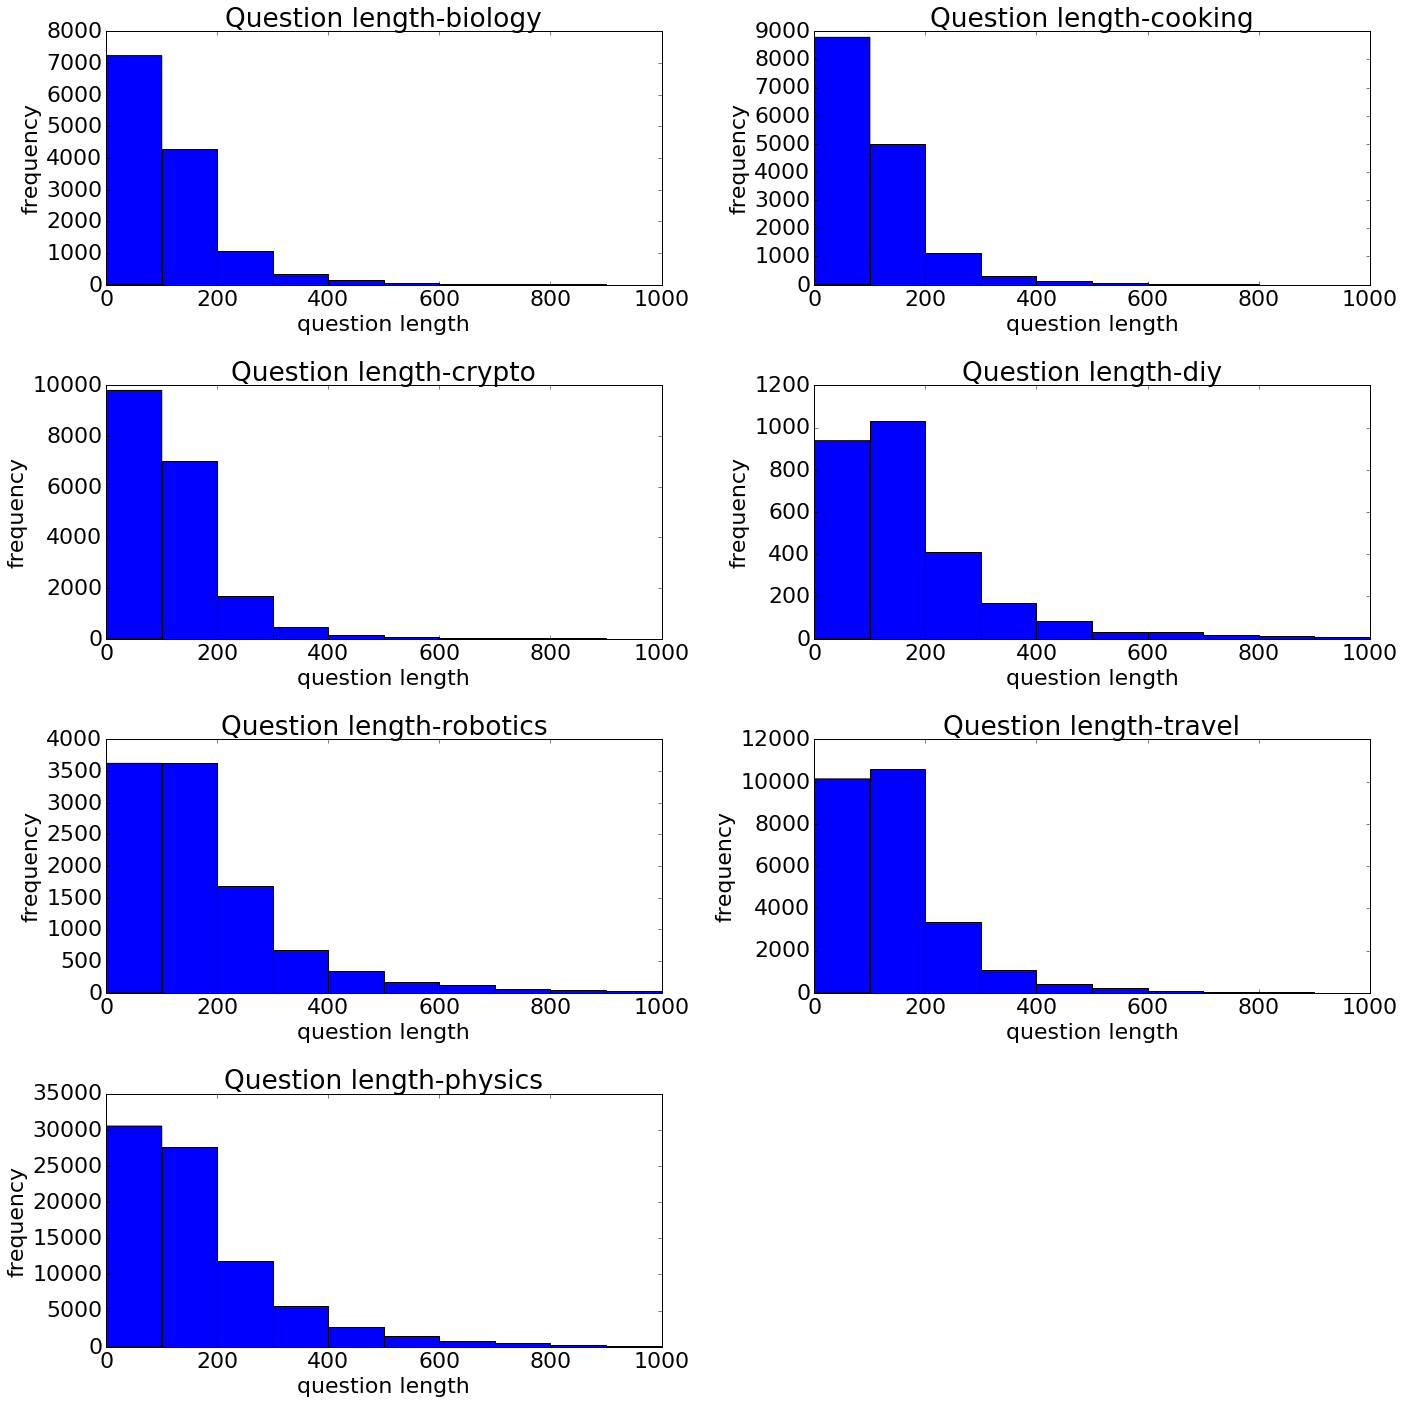

In [48]:
fig = plt.figure(figsize=(20, 20))
for i in range(0, len(topics_dict)):
    topic = topics_dict[i]
    numbers = list(df.loc[df['topic'] == topic, :]['length'])
    ax = fig.add_subplot(420+i+1)
    ax.hist(numbers,range=(0, 1000))
    ax.set_title("Question length-%s"%topic)
    ax.set_ylabel("frequency")
    ax.set_xlabel("question length")
plt.tight_layout()
plt.show()

# Baseline model

In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from time import time
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from visualizer import plot_confusion_matrix

In [150]:
# prepare data
thres = 1000
df_subset = df.loc[df["length"] < thres, :].reset_index()
df_subset = df_subset[['qid', 'combined_text']]

In [151]:
# generate tf-idf features
embed_dim = 10000 # limit the number of features (filtered by term frequency)
vectorizer = TfidfVectorizer(max_features=embed_dim, tokenizer=lambda s: word_tokenize(s, 'english'), stop_words=stopwords.words('english'))
st = time()
doc_term_mat = vectorizer.fit_transform(list(df_subset["combined_text"]))
print("Time elapsed: %.2fs"%(time()-st))

Time elapsed: 201.96s


In [86]:
# train test split
def random_idx(length, test_size=0.25, random_state=1024): # reproducible
    state = np.random.RandomState(random_state)
    return state.rand(length) < 1 - test_size
msk = random_idx(len(df_subset.index))

In [91]:
train_data = doc_term_mat[msk, :]
test_data = doc_term_mat[~msk, :]
train_labels = np.array(list(df_subset[msk]['qid'].apply(lambda x: int(x.split('-')[0]))))
test_labels = np.array(list(df_subset[~msk]['qid'].apply(lambda x: int(x.split('-')[0]))))

In [100]:
# train baseline model
st = time()
gnb = GaussianNB()
gnb.fit(train_data.toarray(), train_labels)
print("Time elapsed: %.2fs"%(time()-st))

Time elapsed: 70.76s


In [ ]:
y_pred = gnb.predict(test_data.toarray())

In [138]:
precision, recall, fscore, _ = \
precision_recall_fscore_support(test_labels, y_pred, average='weighted')
print("Precision: %.2f"%precision)
print("Recall: %.2f"%recall)
print("F1-score: %.2f"%fscore)
print("-"*40)
precision, recall, fscore, _ = \
precision_recall_fscore_support(test_labels, y_pred, average='macro')
print("Precision: %.2f"%precision)
print("Recall: %.2f"%recall)
print("F1-score (unweighted): %.2f"%fscore)

Precision: 0.88
Recall: 0.84
F1-score: 0.85
----------------------------------------
Precision: 0.75
Recall: 0.84
F1-score (unweighted): 0.77


Normalized.


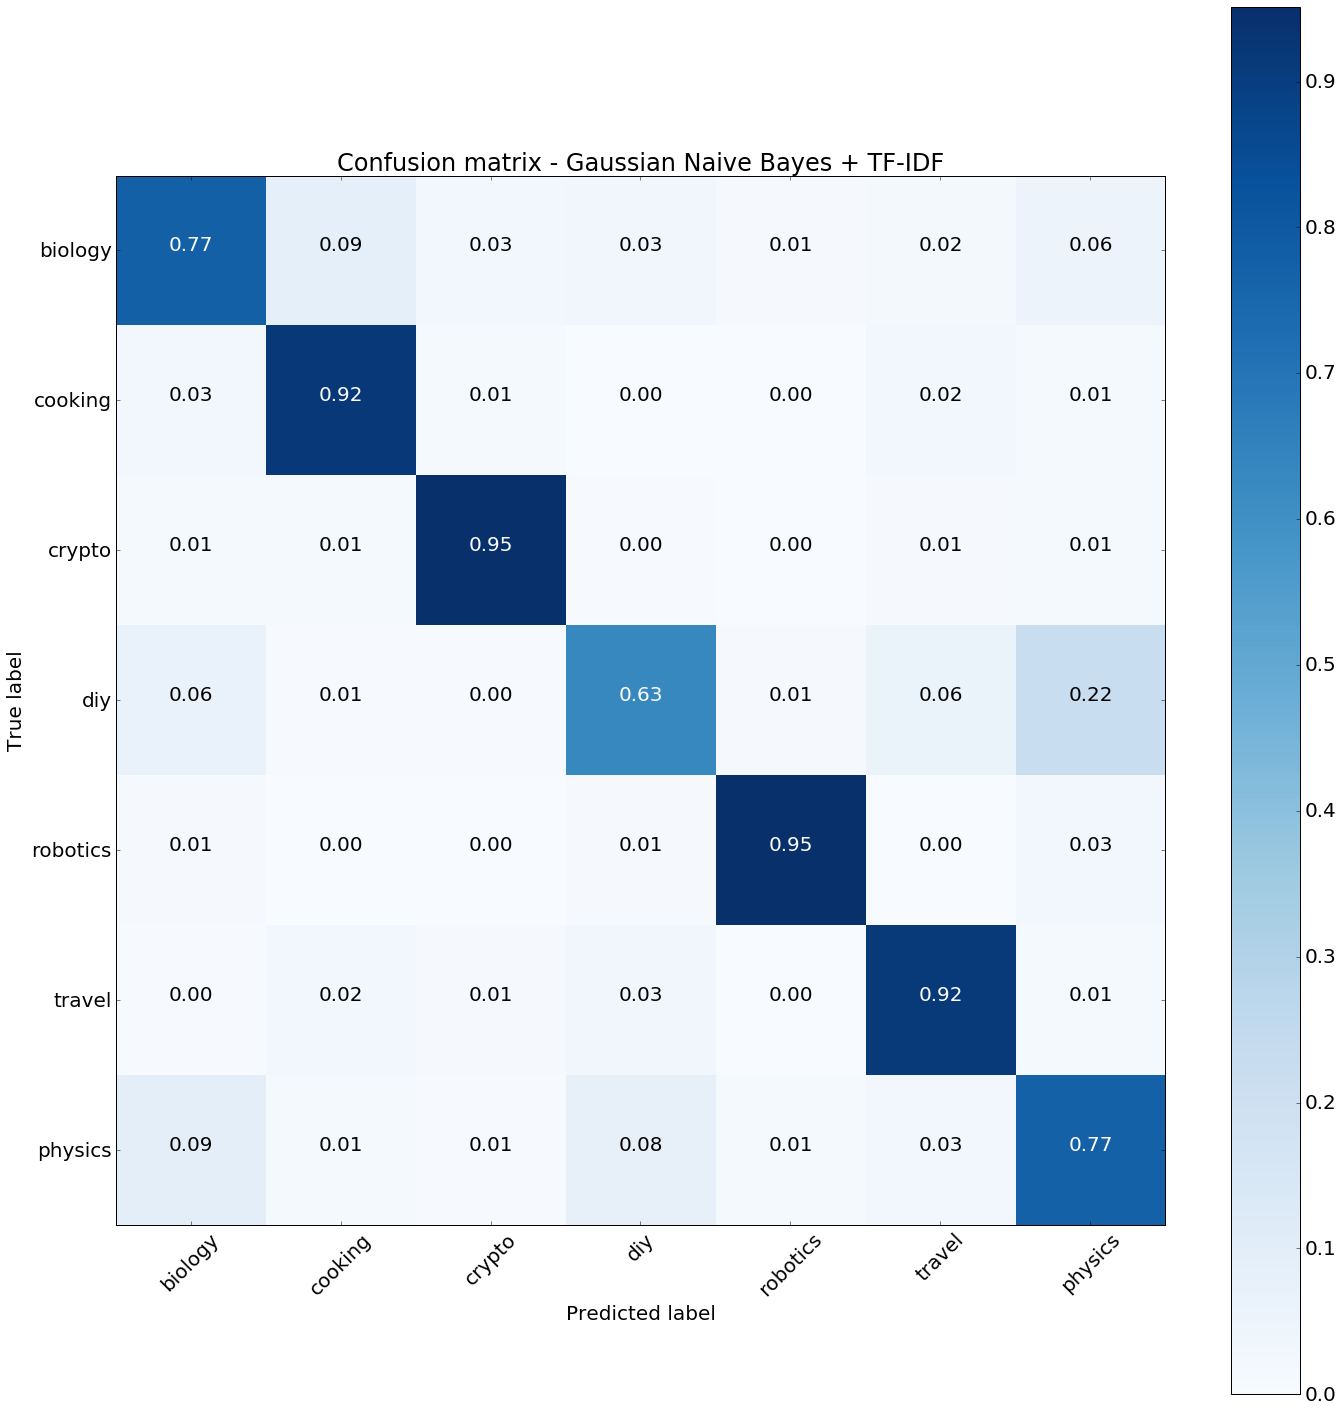

In [135]:
# visualize confusion matrix
topics = train_topics + ['physics']
cnf_mat = confusion_matrix(test_labels, y_pred)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 20))
plot_confusion_matrix(cnf_mat, classes=topics, normalize=True, title='Confusion matrix - Gaussian Naive Bayes + TF-IDF')
plt.show()

# Solution Model

In [10]:
import tensorflow as tf
import pandas as pd
sent_file = '../data/tmp/sentences.csv'
df_sent = pd.read_csv(sent_file, encoding='utf-8')
lookup_dict = dict(zip(list(df_sent['qid']), list(df_sent['id'])))
del df_sent

In [20]:
lookup = pd.DataFrame(lookup_dict.items(), columns=['qid', 'id'])
lookup.head()

,qid,id
0,6-209587,120763
1,6-214008,122366
2,5-4748,70802
3,6-209580,120762
4,1-55940,23760


In [21]:
# inner join
df_join = df_subset.merge(lookup, how='inner', left_on='qid', right_on='qid')
print("nRows: %d"%len(df_join.index))
df_join.head()

nRows: 167005


,qid,combined_text,id
0,0-1,What is the criticality of the ribosome bindin...,0
1,0-2,How is RNAse contamination in RNA based experi...,2793
2,0-3,Are lymphocyte sizes clustered in two groups? ...,5142
3,0-4,How long does antibiotic-dosed LB maintain goo...,7975
4,0-5,Is exon order always preserved in splicing? Ar...,11218


In [138]:
# load document vectors from TF final checkpoint
saver = tf.train.import_meta_graph(\
'/Users/juanyan.li/github/kaggle-transfer-learning-on-stack-exchange-tags/save/model.ckpt-2146931.meta',\
clear_devices=True)
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    saver.restore(sess, '/Users/juanyan.li/github/kaggle-transfer-learning-on-stack-exchange-tags/save/model.ckpt-2146931')
    print("Model restored!")
    var = [ v for v in tf.global_variables() if v.name == u'paragraph_embedding:0']
    embeddings = sess.run(var[0])
    #     embeddings = ph_embed.eval(session=sess)
    # print("Embedding shape: %s"%embeddings.shape)

Model restored!


In [156]:
# train test split
def random_idx(length, test_size=0.25, random_state=1024): # reproducible
    state = np.random.RandomState(random_state)
    return state.rand(length) < 1 - test_size
msk = random_idx(len(df_join.index))
train_ids = np.array(list(df_join[msk]['id']), dtype=np.int32)
test_ids = np.array(list(df_join[~msk]['id']), dtype=np.int32)
train_data_doc2vec = embeddings[train_ids, :]
test_data_doc2vec = embeddings[test_ids, :]
train_data_tfidf = doc_term_mat[msk, :].toarray()
test_data_tfidf = doc_term_mat[~msk, :].toarray()
train_labels = np.array(list(df_join[msk]['qid'].apply(lambda x: int(x.split('-')[0]))), dtype=np.int32)
test_labels = np.array(list(df_join[~msk]['qid'].apply(lambda x: int(x.split('-')[0]))), dtype=np.int32)

In [157]:
def train_test_cls(classifier, train_data, train_labels, test_data, test_labels):
    st = time()
    classifier.fit(train_data, train_labels)
    print("Training finished. Time elapsed: %.2fs"%(time()-st))
    y_pred = classifier.predict(test_data)
    precision, recall, fscore, _ = \
    precision_recall_fscore_support(test_labels, y_pred, average='weighted')
    print("Precision: %.2f"%precision)
    print("Recall: %.2f"%recall)
    print("F1-score: %.2f"%fscore)
    print("-"*40)
    precision, recall, fscore, _ = \
    precision_recall_fscore_support(test_labels, y_pred, average='macro')
    print("Precision: %.2f"%precision)
    print("Recall: %.2f"%recall)
    print("F1-score (unweighted): %.2f"%fscore)
    print("-"*40)
    return classifier

In [160]:
trained_gnb_tfidf = train_test_cls(GaussianNB(), train_data_tfidf, train_labels, test_data_tfidf, test_labels)

Training finished. Time elapsed: 64.37s
Precision: 0.87
Recall: 0.82
F1-score: 0.84
----------------------------------------
Precision: 0.72
Recall: 0.82
F1-score (unweighted): 0.75
----------------------------------------


In [161]:
trained_gnb_doc2vec = train_test_cls(GaussianNB(), train_data_doc2vec, train_labels, test_data_doc2vec, test_labels)

Training finished. Time elapsed: 0.28s
Precision: 0.34
Recall: 0.19
F1-score: 0.16
----------------------------------------
Precision: 0.16
Recall: 0.18
F1-score (unweighted): 0.11
----------------------------------------


In [ ]:
trained_svm_doc2vec = train_test_cls(GaussianNB(), train_data_doc2vec, train_labels, test_data_doc2vec, test_labels)